# Project 3: Semantic Segmentation

#### Maximum Points: 100

This project evaluates your understanding and implementation of a semantic segmentation pipeline. The overall project is divided into several sections, with specific marks assigned to each.


**Mark Distribution**:

<div align = "center">
    <table>
        <tr><td><h3>No.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1.1.</h3></td> <td><h3> Dataset Class</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>1.2</h3></td> <td><h3> Visualize dataset</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2.</h3></td> <td><h3>  Define Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>3.</h3></td> <td><h3>  Model Definition</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4.</h3></td> <td><h3>  Train</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>5.</h3></td> <td><h3>  Inference</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>6.</h3></td> <td><h3> mIoU Score</h3></td> <td><h3>30</h3></td> </tr>
    </table>
        
</div>

---

Breakdown of mIoU Score on Test Dataset **(30 Points)**:

The mIoU Score section evaluates the quality of your segmentation model. Points are awarded based on the achieved mIoU (Mean Intersection over Union) score on the test dataset, as shown below:

<div align="center">
    <table>
        <tr><td><h3>No.</h3></td> <td><h3>mIoU Score Range</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1.</h3></td> <td><h3>>=65% and < 70%</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2.</h3></td> <td><h3>>= 70% and < 73%</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>3.</h3></td> <td><h3>>= 73%</h3></td><td><h3>30</h3></td> </tr>
    </table>
</div>


---
<h2 style = "color: green;">Dataset Description </h2>

For this Semantic Segmentation Project, you will be working on the **[ICPR Retinal Blood Vessels Dataset](https://www.dropbox.com/scl/fi/tscgh3pxwzfvesnu6l6uv/icpr_prepared.zip?rlkey=8oay8sod3jc1hvwhgqvylaefr&st=udj92wmp&dl=1).**


The dataset consists of **268** train images and **112** test images in 2 classes (**veins** and **background**).

There is no separate validation dataset, you can use the given test dataset for validation.

The dataset is structured as follows:

```
icpr_prepared/
├── train_images/
│   ├── image_100.tif
│   ├── image_101.tif
│   └── ...
├── train_labels/
│   ├── image_100.tif
│   ├── image_101.tif
│   └── ...
├── test_images/
│   ├── image_121.tif
│   ├── image_122.tif
│   └── ...
└── test_labels/
    ├── image_121.tif
    ├── image_122.tif
    └── ...

```
---
Images and their corresponding binary masks are of `.tif` file format and are named with a unique `ImageId` as the filename.

Few samples are shown below:

<img src="https://www.dropbox.com/scl/fi/h0z30ptb8o6cyppfs8h4w/segformer_data_viz_grid_2.png?rlkey=tssqlts8o4kea3kf1um3tijjs&st=0sxunbha&dl=1" width="800" height="800">


**The notebook is divided into multiple grading sections. You have to write code, as mentioned for each section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

<h2 style = "color: green;">1. Data Exploration </h2>

In this section, you have to write your custom dataset class and visualize a few images (minimum five images) along with their mask overlayed.

<h2 style = "color: green;">1.1. Dataset Class [15 Points]</h2>

**In this sub-section, write your custom dataset class.**

**For example:**

```python
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            train_image: path to input train images
            train_mask: path to input train mask labels
            train_tfms: transformations (if any)
            label_colors_list: mapping of label value to color code
            classes_to_train: number of classes

            Names of images in the images_folder and masks_folder should be the same for the same samples.
    """
```

In [1]:
import os
import zipfile
import requests

In [2]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with zipfile.ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0]) 
            print("Done")
    except:
        print("Invalid file")

In [3]:
URL = r"https://www.dropbox.com/scl/fi/tscgh3pxwzfvesnu6l6uv/icpr_prepared.zip?rlkey=8oay8sod3jc1hvwhgqvylaefr&st=udj92wmp&dl=1"

dataset_name = "retinal_blood_vessel_icpr_seg"
dataset_zip_path = os.path.join(os.getcwd(), f"{dataset_name}.zip")
dataset_path = os.path.join(os.getcwd(), dataset_name)

# Download if dataset does not exists.
if not os.path.exists(dataset_path):
   download_and_unzip(URL, dataset_zip_path)

In [1]:
from PIL import Image
import torchvision.transforms.functional as TF
import random
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class SemSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.size = size  # (H, W)
        self.filenames = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, fname)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale

        # Resize both image and mask to same size
        image = image.resize(self.size[::-1], Image.BILINEAR)  # PIL uses (W, H)
        mask = mask.resize(self.size[::-1], Image.NEAREST)     # Nearest for masks

        # Convert to tensor
        image = TF.to_tensor(image)  # Shape: [3, H, W]
        mask = torch.from_numpy(np.array(mask))  # Shape: [H, W]
        mask = (mask > 0).long()  # Binary: 0 or 1

        return image, mask

<h2 style = "color: green;">1.2. Visualize dataset [10 Points]</h2>


**In this sub-section,  you have to plot a few images and its mask.**

**For example:**

---

<img src="https://www.dropbox.com/scl/fi/hrkxc7vlziawumy7pwfbt/grid_22.png?rlkey=d9jrybjc993qtbzngekj1sseu&st=7rsy2rik&dl=1">

---

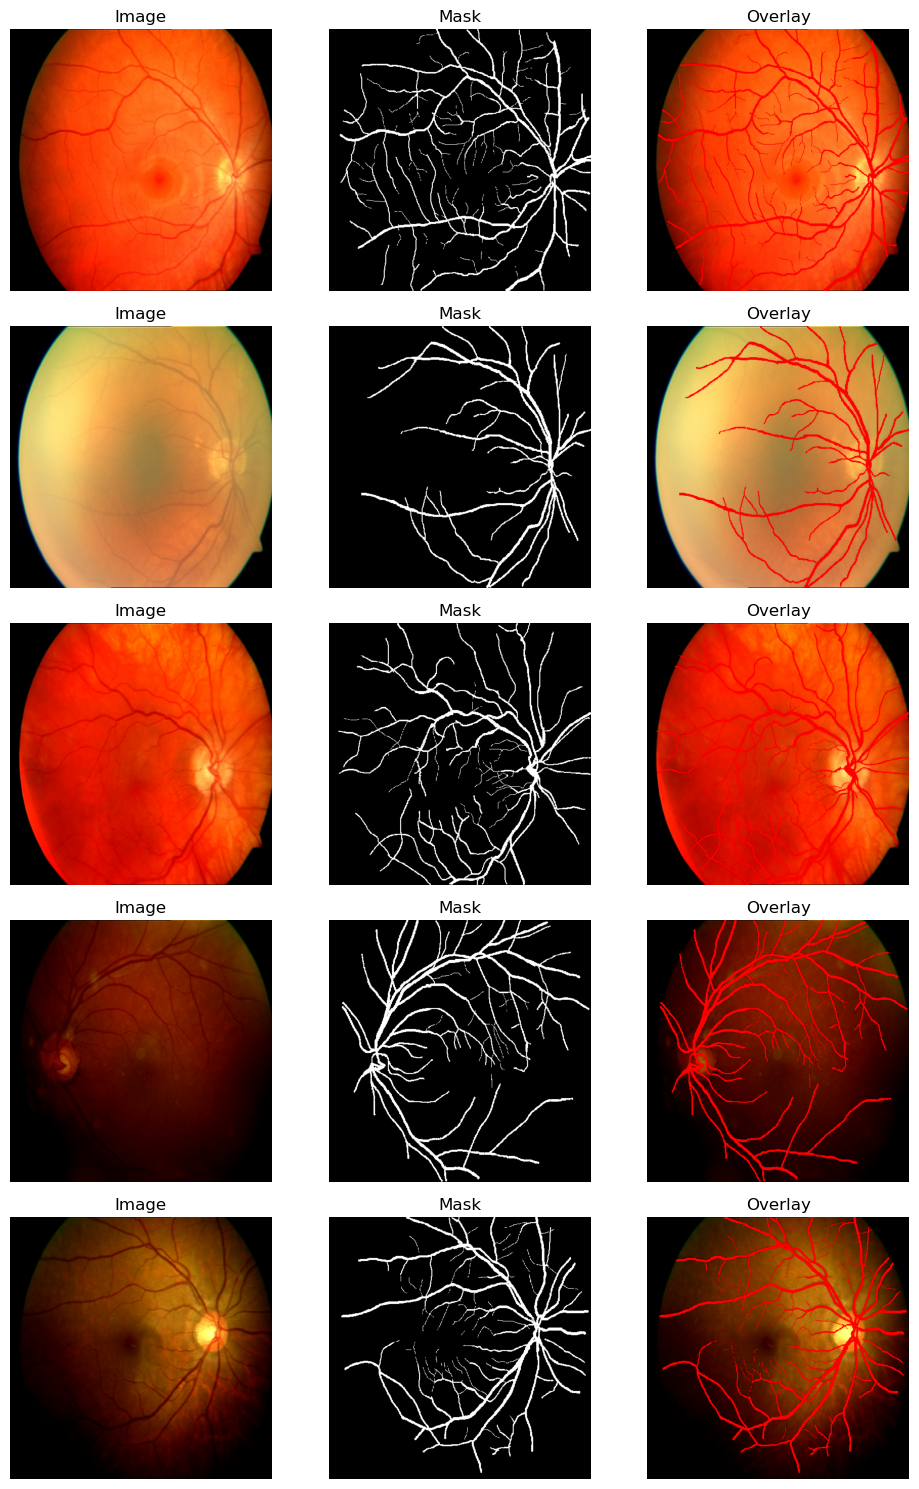

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define transforms
train_tfms = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
])

# Load dataset
dataset_path = "retinal_blood_vessel_icpr_seg"
train_img_dir = os.path.join(dataset_path, "train_images")
train_mask_dir = os.path.join(dataset_path, "train_labels")

train_dataset = SemSegDataset(train_img_dir, train_mask_dir, transform=train_tfms)

# Plot 5 samples
fig, axes = plt.subplots(5, 3, figsize=(10, 15))
for i in range(5):
    img, mask = train_dataset[i]
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # Overlay
    overlay = img_np.copy()
    overlay[mask_np == 1] = [1, 0, 0]  # Red for vessels

    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_np, cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

<h2 style = "color: green;">2. Define Evaluation Metrics [10 Points]</h2>


This project is evaluated on the mean <a href='https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/'>IoU</a>.

Mean Intersection over Union (mIoU) is a metric that measures the average overlap between predicted and actual objects in an image or set of images. It's calculated by averaging the Intersection over Union (IoU) of each class in an image.

The following illustration helps in better understanding the IoU:

<img src = "https://www.dropbox.com/scl/fi/e67ri02rqou5oeazdh3rb/intersection-over-union-iou.jpg?rlkey=x5fi1ke6svoas4rh7mfxn3ro7&st=peahed63&dl=1" >

**In this section, you have to implement the mIoU evaluation metric.**

In [3]:
def calculate_iou(pred, target, num_classes=2):
    """
    Compute IoU per class and mean IoU.
    pred: (H, W) predicted class labels
    target: (H, W) ground truth labels
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou = torch.tensor(1.0)  # No ground truth or prediction → perfect
        else:
            iou = intersection / union
        ious.append(iou)
    return torch.mean(torch.stack(ious)).item(), [iou.item() for iou in ious]

def calculate_miou_batch(preds, targets, num_classes=2):
    """Compute mIoU over a batch."""
    total_miou = 0.0
    for p, t in zip(preds, targets):
        miou, _ = calculate_iou(p, t, num_classes)
        total_miou += miou
    return total_miou / len(preds)

<h2 style = "color: green;">3. Model [10 Points]</h2>

**In this section, you have to define your model.**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

<h2 style = "color: green;">4. Train & Inference</h2>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**

<h2 style = "color: green;">4.1. Train [15 Points]</h2>


**Write your training code in this section.**


**This section must contain training plots (use matplotlib or share tensorboard scalars logs).**

**You must have to plot the following:**
- **train loss and validation loss**


- **train accuracy and validation accuracy**


- **Mean Intersection over Union (mIoU) of these classes on validation data.**

**An example of training plots is shown below:**

---

<img src='https://www.dropbox.com/scl/fi/c09gejfn8ivhapp2ngott/loss.png?rlkey=6pennpz1959plb84jlfjytw4p&st=e6ppi338&dl=1'>

---

<img src='https://www.dropbox.com/scl/fi/9h83bbzkifn2kon0gu3wi/accuracy.png?rlkey=v0q17rmi1djljny7ykr0ydk7b&st=zxze36ro&dl=1'>

---

<img src='https://www.dropbox.com/scl/fi/0pq7ivltoeyp1mlkv85oh/miou.png?rlkey=g4iuqvbwih9ld6efvayz5lgjj&st=5bpihwaz&dl=1'>



In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Paths
train_img_dir = os.path.join(dataset_path, "train_images")
train_mask_dir = os.path.join(dataset_path, "train_labels")
test_img_dir = os.path.join(dataset_path, "test_images")
test_mask_dir = os.path.join(dataset_path, "test_labels")

# Transforms
transform = T.Compose([
    T.ToTensor(),
])

# Datasets
train_dataset = SemSegDataset(
    train_img_dir,
    train_mask_dir,
    size=(512, 512)
)
test_dataset = SemSegDataset(test_img_dir, test_mask_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
train_losses, val_losses = [], []
train_mious, val_mious = [], []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_miou = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        miou = calculate_miou_batch(preds.cpu(), masks.cpu())
        epoch_miou += miou

    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_miou = epoch_miou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_mious.append(avg_train_miou)

    # Validation
    model.eval()
    val_loss = 0.0
    val_miou = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            miou = calculate_miou_batch(preds.cpu(), masks.cpu())
            val_miou += miou

    avg_val_loss = val_loss / len(test_loader)
    avg_val_miou = val_miou / len(test_loader)
    val_losses.append(avg_val_loss)
    val_mious.append(avg_val_miou)

    print(f"Train Loss: {avg_train_loss:.4f}, Train mIoU: {avg_train_miou:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val mIoU: {avg_val_miou:.4f}")

Epoch 1/30: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]


Train Loss: 0.5756, Train mIoU: 0.4735
Val Loss: 0.6541, Val mIoU: 0.4538


Epoch 2/30: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


Train Loss: 0.4394, Train mIoU: 0.5686
Val Loss: 0.4614, Val mIoU: 0.4626


Epoch 3/30: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Train Loss: 0.3954, Train mIoU: 0.6100
Val Loss: 0.4282, Val mIoU: 0.5722


Epoch 4/30: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Train Loss: 0.3693, Train mIoU: 0.6253
Val Loss: 0.4246, Val mIoU: 0.5988


Epoch 5/30: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Train Loss: 0.3440, Train mIoU: 0.6479
Val Loss: 0.3466, Val mIoU: 0.6073


Epoch 6/30: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Train Loss: 0.3320, Train mIoU: 0.6601
Val Loss: 0.3334, Val mIoU: 0.6124


Epoch 7/30: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]


Train Loss: 0.3119, Train mIoU: 0.6667
Val Loss: 0.3217, Val mIoU: 0.6393


Epoch 8/30: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Train Loss: 0.2932, Train mIoU: 0.6780
Val Loss: 0.3174, Val mIoU: 0.6429


Epoch 9/30: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Train Loss: 0.2866, Train mIoU: 0.6754
Val Loss: 0.2916, Val mIoU: 0.6351


Epoch 10/30: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Train Loss: 0.2709, Train mIoU: 0.6863
Val Loss: 0.2817, Val mIoU: 0.6644


Epoch 11/30: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Train Loss: 0.2588, Train mIoU: 0.6907
Val Loss: 0.2661, Val mIoU: 0.6576


Epoch 12/30: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Train Loss: 0.2492, Train mIoU: 0.6952
Val Loss: 0.2720, Val mIoU: 0.6667


Epoch 13/30: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Train Loss: 0.2405, Train mIoU: 0.7016
Val Loss: 0.2509, Val mIoU: 0.6637


Epoch 14/30: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Train Loss: 0.2326, Train mIoU: 0.7027
Val Loss: 0.2312, Val mIoU: 0.6728


Epoch 15/30: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Train Loss: 0.2237, Train mIoU: 0.7060
Val Loss: 0.2793, Val mIoU: 0.6840


Epoch 16/30: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Train Loss: 0.2225, Train mIoU: 0.6996
Val Loss: 0.2372, Val mIoU: 0.6469


Epoch 17/30: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Train Loss: 0.2165, Train mIoU: 0.6933
Val Loss: 0.2371, Val mIoU: 0.6823


Epoch 18/30: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Train Loss: 0.2085, Train mIoU: 0.7019
Val Loss: 0.2126, Val mIoU: 0.6629


Epoch 19/30: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s]


Train Loss: 0.2006, Train mIoU: 0.7106
Val Loss: 0.2093, Val mIoU: 0.6809


Epoch 20/30: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Train Loss: 0.1941, Train mIoU: 0.7161
Val Loss: 0.2012, Val mIoU: 0.6966


Epoch 21/30: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Train Loss: 0.1896, Train mIoU: 0.7160
Val Loss: 0.1960, Val mIoU: 0.6951


Epoch 22/30: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Train Loss: 0.1849, Train mIoU: 0.7192
Val Loss: 0.1978, Val mIoU: 0.7019


Epoch 23/30: 100%|██████████| 18/18 [00:07<00:00,  2.25it/s]


Train Loss: 0.1792, Train mIoU: 0.7255
Val Loss: 0.1925, Val mIoU: 0.7022


Epoch 24/30: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]


Train Loss: 0.1756, Train mIoU: 0.7249
Val Loss: 0.1875, Val mIoU: 0.7046


Epoch 25/30: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Train Loss: 0.1703, Train mIoU: 0.7318
Val Loss: 0.1819, Val mIoU: 0.6961


Epoch 26/30: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Train Loss: 0.1676, Train mIoU: 0.7304
Val Loss: 0.1768, Val mIoU: 0.7088


Epoch 27/30: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s]


Train Loss: 0.1645, Train mIoU: 0.7336
Val Loss: 0.1696, Val mIoU: 0.7139


Epoch 28/30: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Train Loss: 0.1641, Train mIoU: 0.7322
Val Loss: 0.1740, Val mIoU: 0.7085


Epoch 29/30: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Train Loss: 0.1583, Train mIoU: 0.7359
Val Loss: 0.1639, Val mIoU: 0.7211


Epoch 30/30: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Train Loss: 0.1544, Train mIoU: 0.7399
Val Loss: 0.1599, Val mIoU: 0.7148


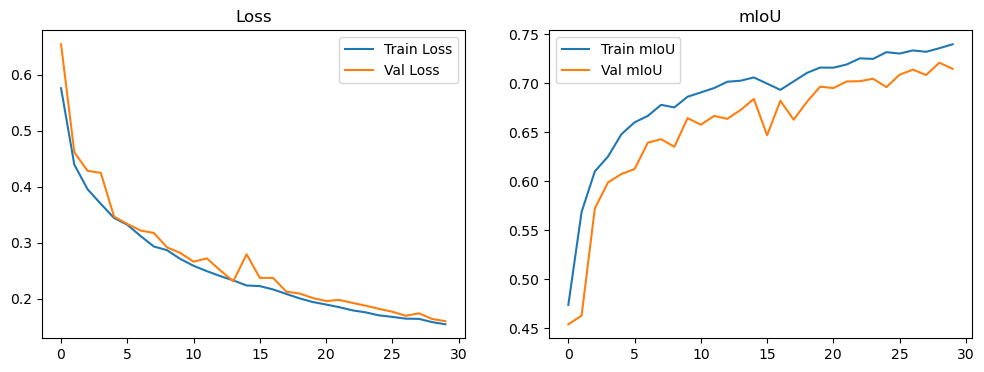

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mious, label='Train mIoU')
plt.plot(val_mious, label='Val mIoU')
plt.title("mIoU")
plt.legend()

plt.show()

<h2 style = "color: green;">5. Inference [10 Points]</h2>

**Plot a few samples with the test image, predicted mask and the predicted mask overlayed onto the retinal eye image.**

**For example:**

---

<img src='https://www.dropbox.com/scl/fi/re6sw5od5k59u4bwgbfgy/prediction_overlay_segformer.png?rlkey=a34frfceiq2pawoovm4zx7b5r&st=qi3fivau&dl=1'>

---



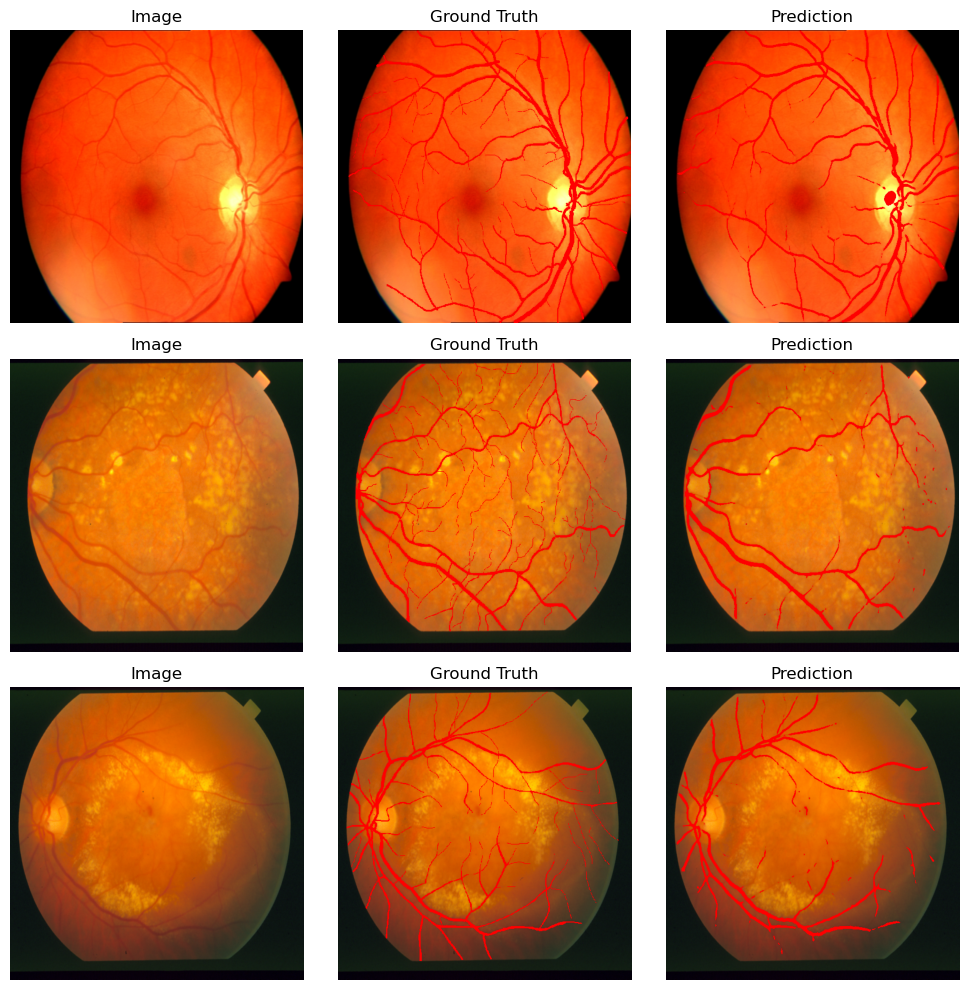

In [10]:
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

with torch.no_grad():
    for i, (img, mask) in enumerate(test_dataset):
        if i >= 3:
            break
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(output, dim=1).cpu().squeeze(0)

        img_np = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        pred_np = pred.numpy()

        overlay_true = img_np.copy()
        overlay_true[mask_np == 1] = [1, 0, 0]

        overlay_pred = img_np.copy()
        overlay_pred[pred_np == 1] = [1, 0, 0]

        axes[i, 0].imshow(img_np, cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(overlay_true)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
model.eval()
total_miou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        miou = calculate_miou_batch(preds.cpu(), masks.cpu())
        total_miou += miou

final_miou = total_miou / len(test_loader)
print(f"Final Test mIoU: {final_miou * 100:.2f}%")

Final Test mIoU: 71.48%
